# Assignment 2
*Email: l.kayirly@innopolis.university | Name: Alimzhan Kaiyrly | Group: B20-DS*

-------------------------------------------------------------------------------------

Data preprocessing and initial exploration

1. Preprocessing the data from MovieLens-100k dataset. Converting from original format to 3 dataframes: movies, ratings, users

###### | Script from the following github repo was used: https://github.com/Blosc/movielens-bench/blob/master/process-100k.py |

In [91]:
from time import time
import os.path
import numpy as np
import bcolz
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from uszipcode import SearchEngine

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [10]:
bcolz.print_versions()

dset = '../data/raw/ml-100k'
fuser = os.path.join(dset, 'u.user')
fdata = os.path.join(dset, 'u.data')
fitem = os.path.join(dset, 'u.item')

bcolz.defaults.cparams['cname'] = 'lz4'
bcolz.defaults.cparams['clevel'] = 1

# pass in column names for each CSV
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(fuser, sep='|', names=u_cols)

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(fdata, sep='\t', names=r_cols)

# the movies file contains columns indicating the movie's genres
# let's only load the first five columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv(fitem, sep='|', names=m_cols, usecols=range(5),
                     dtype={'release_date': "S100", 'imdb_url': "S200"}, encoding='latin-1')

t0 = time()
# create one merged DataFrame
movie_ratings = pd.merge(movies, ratings)
lens = pd.merge(movie_ratings, users)
print("Time for merging the datasets: %.2f" % (time()-t0,)) 


t0 = time()
result = lens.query("title == 'Tom and Huck (1995)'")
print("time (and length) for simple query with pandas: %.2f (%d)" %
      (time()-t0, len(result)))

t0 = time()
result = lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']
print("time (and length) for complex query with pandas: %.2f (%d)" %
      (time()-t0, len(result)))


t0 = time()
zlens = bcolz.ctable.fromdataframe(lens)
print("time (and compress ratio) for ctable conversion: %.2f (%.1fx)" % 
      (time()-t0, zlens.nbytes / float(zlens.cbytes)))

t0 = time()
result = zlens["title == 'Tom and Huck (1995)'"]
print("time (and length) for simple query with bcolz: %.2f (%d)" %
      (time()-t0, len(result)))

t0 = time()
result = [r.user_id for r in zlens.where(
    "(title == 'Tom and Huck (1995)') & (rating == 5)", outcols=['user_id'])]
print("time (and length) for complex query with bcolz: %.2f (%d)" %
      (time()-t0, len(result)))

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
bcolz version:     0.1.dev1
NumPy version:     1.23.5
Blosc version:     1.21.1.dev0 ($Date:: 2020-12-22 #$)
Blosc compressors: ['blosclz', 'lz4', 'lz4hc', 'zlib', 'zstd']
Numexpr version:   not available (version >= 2.5.2 not detected)
Dask version:      not available (version >= 0.9.0 not detected)
Python version:    3.10.4 (tags/v3.10.4:9d38120, Mar 23 2022, 23:13:41) [MSC v.1929 64 bit (AMD64)]
Byte-ordering:     little
Detected cores:    8
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Time for merging the datasets: 0.06
time (and length) for simple query with pandas: 0.01 (12)
time (and length) for complex query with pandas: 0.00 (1)
time (and compress ratio) for ctable conversion: 6.83 (2.9x)
time (and length) for simple query with bcolz: 1.69 (12)
time (and length) for complex query with bcolz: 0.02 (1)


In [33]:
users

,user_id,age,sex,occupation,zip_code,age_group
0,1,24,M,technician,85711,Young
1,2,53,F,other,94043,Midlife
2,3,23,M,writer,32067,Young
3,4,24,M,technician,43537,Young
4,5,33,F,other,15213,Young
...,...,...,...,...,...,...
938,939,26,F,student,33319,Young
939,940,32,M,administrator,02215,Young
940,941,20,M,student,97229,Young
941,942,48,F,librarian,78209,Midlife


In [17]:
# Merge the dataframes into one
movie_ratings = pd.merge(ratings, movies, on='movie_id')
user_movie_ratings = pd.merge(movie_ratings, users, on='user_id')

------------------------------------------------------

##  2. Let's explore and preprocess resulting dataframe. 
Steps taken: 
* Check for null data
* Drop columns

-------------------------------------------------

In [19]:
user_movie_ratings.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,age,sex,occupation,zip_code
0,196,242,3,881250949,Kolya (1996),b'24-Jan-1997',NaN,b'http://us.imdb.com/M/title-exact?Kolya%20(19...,49,M,writer,55105
1,196,257,2,881251577,Men in Black (1997),b'04-Jul-1997',NaN,b'http://us.imdb.com/M/title-exact?Men+in+Blac...,49,M,writer,55105
2,196,111,4,881251793,"Truth About Cats & Dogs, The (1996)",b'26-Apr-1996',NaN,b'http://us.imdb.com/M/title-exact?Truth%20Abo...,49,M,writer,55105
3,196,25,4,881251955,"Birdcage, The (1996)",b'08-Mar-1996',NaN,"b'http://us.imdb.com/M/title-exact?Birdcage,%2...",49,M,writer,55105
4,196,382,4,881251843,"Adventures of Priscilla, Queen of the Desert, ...",b'01-Jan-1994',NaN,b'http://us.imdb.com/M/title-exact?Adventures%...,49,M,writer,55105


In [20]:
user_movie_ratings.isna().sum()

user_id                    0
movie_id                   0
rating                     0
unix_timestamp             0
title                      0
release_date               0
video_release_date    100000
imdb_url                   0
age                        0
sex                        0
occupation                 0
zip_code                   0
dtype: int64

In [21]:
user_movie_ratings = user_movie_ratings.drop(columns=['unix_timestamp', 'video_release_date', 'imdb_url'])

# video_release_date - consists from NaN values, we can drop it
# imdb_url - consists from links that are not useful, we can drop it
# unix_timestamp - consists from unnecessary data, we can drop it

In [23]:
user_movie_ratings.head()

,user_id,movie_id,rating,title,release_date,age,sex,occupation,zip_code
0,196,242,3,Kolya (1996),b'24-Jan-1997',49,M,writer,55105
1,196,257,2,Men in Black (1997),b'04-Jul-1997',49,M,writer,55105
2,196,111,4,"Truth About Cats & Dogs, The (1996)",b'26-Apr-1996',49,M,writer,55105
3,196,25,4,"Birdcage, The (1996)",b'08-Mar-1996',49,M,writer,55105
4,196,382,4,"Adventures of Priscilla, Queen of the Desert, ...",b'01-Jan-1994',49,M,writer,55105


In [25]:
user_movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       100000 non-null  int64 
 1   movie_id      100000 non-null  int64 
 2   rating        100000 non-null  int64 
 3   title         100000 non-null  object
 4   release_date  100000 non-null  object
 5   age           100000 non-null  int64 
 6   sex           100000 non-null  object
 7   occupation    100000 non-null  object
 8   zip_code      100000 non-null  object
dtypes: int64(4), object(5)
memory usage: 7.6+ MB


-------------------------------------------------

## 3. Some data analysis
Let's answer some questions regarding our data. 

Mainly:
* Which age group watches movies the most?
* What people(occupation-wise) watch movies?
* How ratings differ considering the gender of a person?
* What are the top 10 rated movies?
* Where are users from(top 10)?

------------------------------------------------------

In [38]:
users['age_group'] = users.age.apply(lambda age: 'Gradeschooler' if 5<=age<=12 else ('Teenager' if 13<=age<=19 else ('Young' if 20<=age<=35 else ('Midlife' if 35<=age<=55 else 'Old'))))
users.sample(5)

,user_id,age,sex,occupation,zip_code,age_group
765,766,42,M,other,10960,Midlife
617,618,15,F,student,44212,Teenager
178,179,15,M,entertainment,20755,Teenager
114,115,31,M,engineer,17110,Young
736,737,30,M,programmer,98072,Young


Text(0.5, 1.0, 'movie watchers age_group wise')

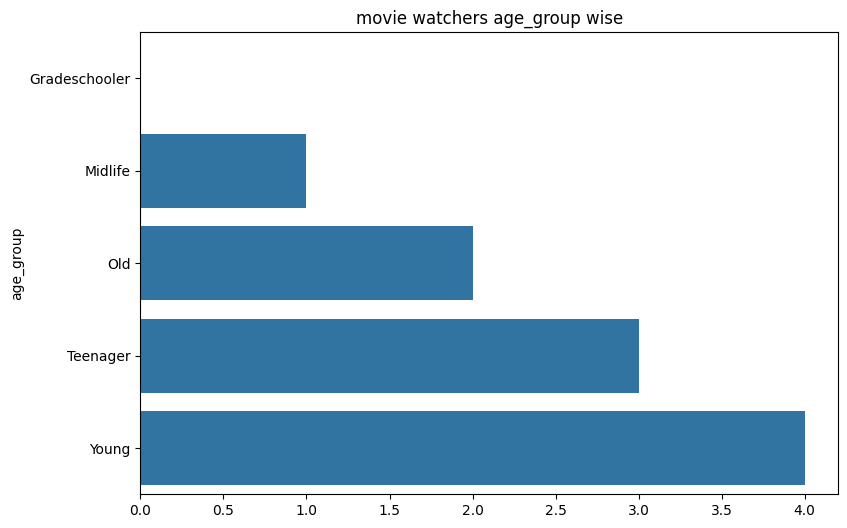

In [39]:
plt.figure(figsize=(9,6))
sns.barplot(users.groupby('age_group').size().index)
plt.title('movie watchers age_group wise')

<span style="color:cyan">Which age group watches movies the most?</span>

Graph shows that relatively young people, under 35 to 13 watch and rate movies, so big portion of ratings come from this group


Text(0.5, 1.0, 'movie watchers occupation wise')

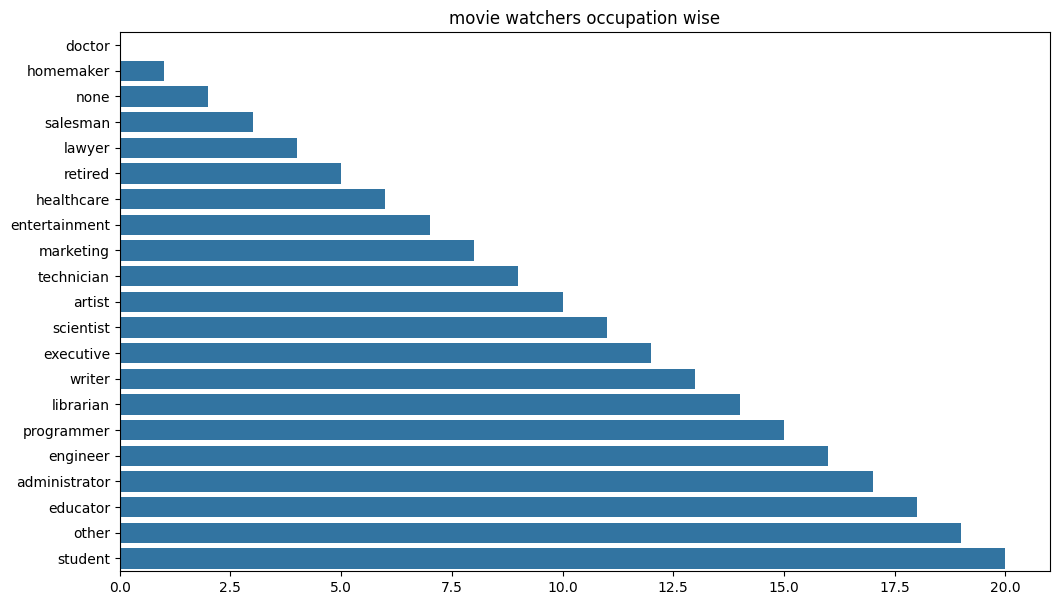

In [49]:
plt.figure(figsize=(12,7))
occupantion = users.groupby('occupation').size().sort_values(ascending=True)
sns.barplot(occupantion.index.values)
plt.title('movie watchers occupation wise')

<span style="color:cyan">What people(occupation-wise) watch movies?</span>

Relatively to first question we can see that majority of users are students

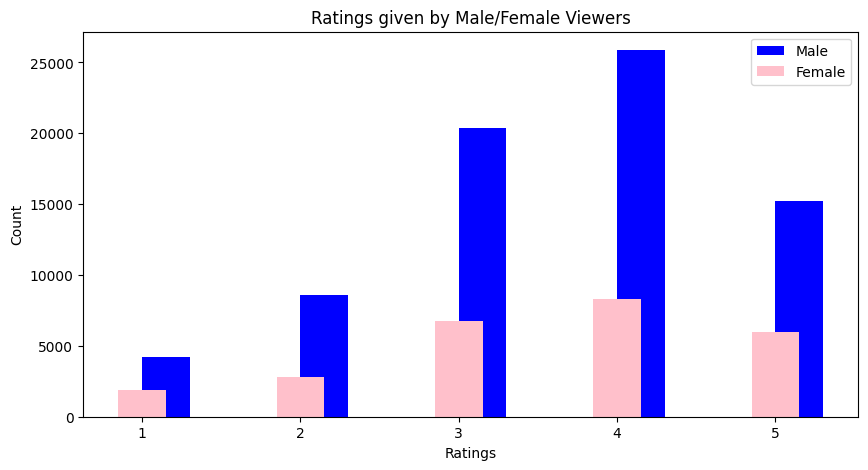

In [54]:
temp_df = user_movie_ratings.groupby(['sex', 'rating']).size()
plt.figure(figsize=(10, 5))
m_temp_df = temp_df.M.sort_values(ascending=False)
f_temp_df = temp_df.F.sort_values(ascending=False)

plt.bar(x=m_temp_df.index, height=m_temp_df.values, label="Male", align="edge", width=0.3, color='blue')
plt.bar(x=f_temp_df.index, height=f_temp_df.values, label="Female", width=0.3, color='pink')
plt.title('Ratings given by Male/Female Viewers')
plt.legend()
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

<span style="color:cyan">How ratings differ considering the gender of a person?</span>

Much of the ratings were given by Males, compared to Females

In [64]:
def draw_bar(titles, ratings_count, title=''):
    plt.figure(figsize=(12, 7))
    sns.barplot(y=titles, x=ratings_count, orient='h')
    plt.title(title)
    plt.ylabel('Movies')
    plt.xlabel('Count')
    plt.show()

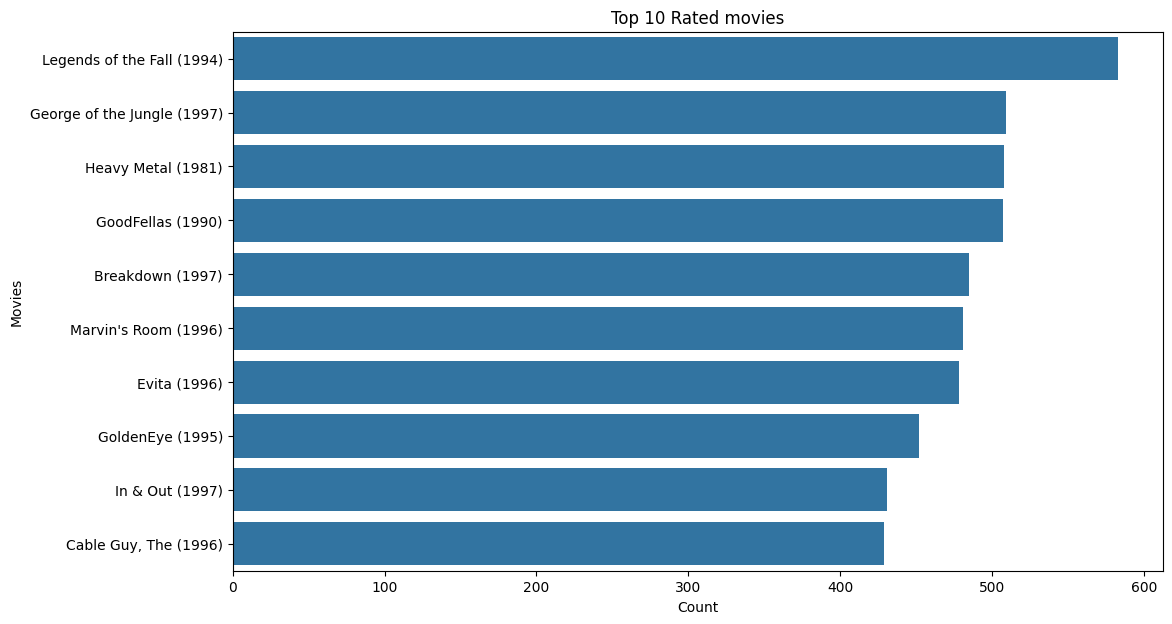

In [71]:
top_ten_rated_movies = user_movie_ratings.groupby('movie_id').size().sort_values(ascending=False)[:10]
top_ten_movie_titles = movies.iloc[top_ten_rated_movies.index]['title']

draw_bar(top_ten_movie_titles.values, top_ten_rated_movies.values, 'Top 10 Rated movies')


<span style="color:cyan">What are the top 10 rated movies?</span>

There we can see top-rated movies

In [105]:
# Convert zip code to states using SearchEngine

data = users['zip_code']
df = pd.DataFrame(data)

def zip_to_state(zip_code):
    search = SearchEngine()
    result = search.by_zipcode(str(zip_code))
    if result:
        return result.state
    else:
        return None

df['State'] = df['zip_code'].apply(zip_to_state)

print(df)

    zip_code State
0      85711    AZ
1      94043    CA
2      32067    FL
3      43537    OH
4      15213    PA
..       ...   ...
938    33319    FL
939    02215    MA
940    97229    OR
941    78209    TX
942    77841    TX

[943 rows x 2 columns]


In [107]:
df['State'].fillna(value=df['State'].mode()[0], inplace=True) #Fill missing values with mode

Text(0.5, 1.0, 'movie watchers geographically wise')

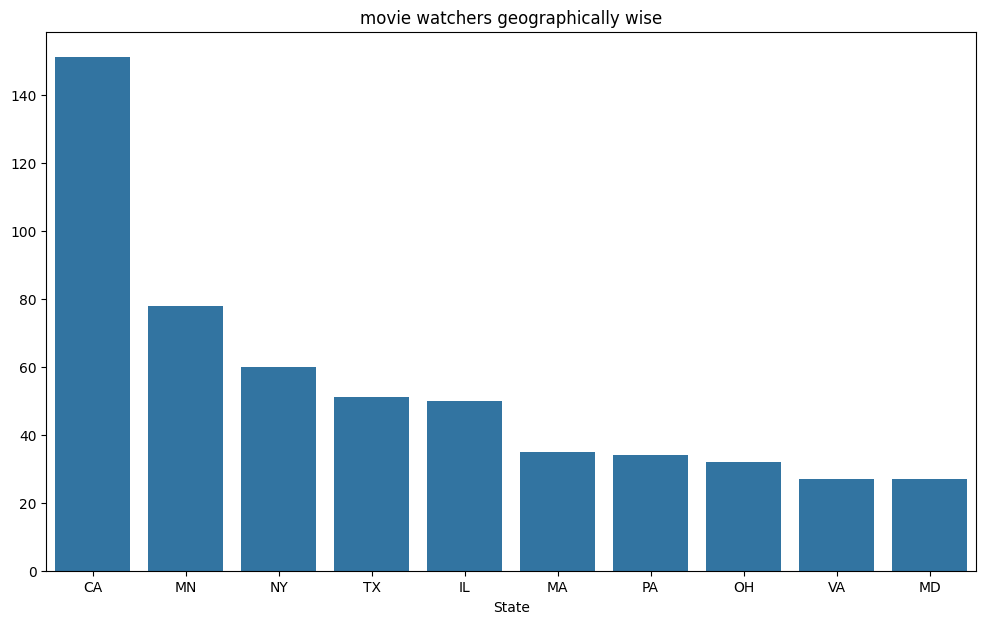

In [109]:
df = df.groupby('State').size().sort_values(ascending=False)[:10]

plt.figure(figsize=(12, 7))
sns.barplot(df)
plt.title('movie watchers geographically wise')

<span style="color:cyan">Where are users from(top 10)?</span>

There we can see the geospatial information regarding our users

----------------------------------------

## 4. Saving dataframe for future use

In [111]:
user_movie_ratings.sample(10)
user_movie_ratings.to_csv('../data/internim/user_movie_ratings.csv', index=False)

In [113]:
movies.sample(10)
movies.drop(columns=['video_release_date', 'imdb_url'], inplace=True)
movies.to_csv('../data/internim/movies.csv', index=False)

In [115]:
users.sample(10)
users.drop(columns=['age_group'], inplace=True)
users.to_csv('../data/internim/users.csv', index=False)

In [120]:
ratings.sample(10)
ratings.to_csv('../data/internim/ratings.csv', index=False)

In [122]:
movie_ratings.sample(10)
movie_ratings.drop(columns=['video_release_date', 'imdb_url', 'unix_timestamp'], inplace=True)
movie_ratings.to_csv('../data/internim/movie_ratings.csv', index=False)